# <center>Data Analytics laboratory </center>

## <center>Prior and Posterior predictive distributions</center>

In [1]:
from cmdstanpy import CmdStanModel
import pandas as pd
import arviz as az 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Modeling prior predictive distribution

We want to choose a prior distribution with a mean of 20% and a wide range.  
     
In this case, we could use a beta distribution with parameters α and β. We want a mean of 0.2 and wide range - so I assumed a variance of 0.05. From forumals:   
$\alpha = \mu \cdot \left(\frac{\mu \cdot (1-\mu)}{\sigma^2} - 1\right)$ = 0.2 * ((0.2 * (1 - 0.2) / 0.05) - 1) ≈ 1.6   
$\beta = (1-\mu) \cdot \left(\frac{\mu \cdot (1-\mu)}{\sigma^2} - 1\right)$ = 0.8 * ((0.2 * (1 - 0.2) / 0.05) - 1) ≈ 6.4


In [2]:
%%writefile code_2_1.stan

generated quantities {
  int<lower=0> N=50;
  int<lower=0,upper=N> y;
  real<lower=0,upper=1> p;
  p=beta_rng(1.6, 6.4);
  y=binomial_rng(N, p);
}

Overwriting code_2_1.stan


In [3]:
gen_quant = CmdStanModel(stan_file='code_2_1.stan')
samples = gen_quant.sample(fixed_param=True, 
                            iter_sampling=1000, 
                            iter_warmup=0)

INFO:cmdstanpy:compiling stan file /code_2_1.stan to exe file /code_2_1
INFO:cmdstanpy:compiled model executable: /code_2_1
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [4]:
samples.column_names

('lp__', 'accept_stat__', 'N', 'y', 'p')

In [5]:
df = pd.DataFrame(samples.draws()[:,:, 2:].reshape((1000, 3)))
df.columns = samples.column_names[2:]
df

,N,y,p
0,50.0,17.0,0.282338
1,50.0,14.0,0.191181
2,50.0,5.0,0.031033
3,50.0,25.0,0.507039
4,50.0,14.0,0.161867
...,...,...,...
995,50.0,12.0,0.215125
996,50.0,23.0,0.504344
997,50.0,9.0,0.238252
998,50.0,10.0,0.157166


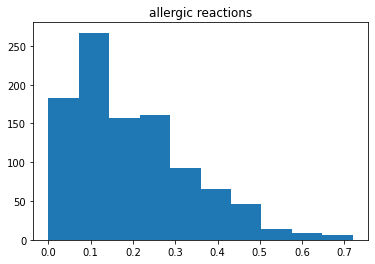

In [7]:
y = df.iloc[:, 1]
N = df.iloc[:, 0]
ratio = y/N

plt.hist(ratio)
plt.title("allergic reactions ratio")
plt.show()


In [10]:
# Verify if mean of the ratio is consistent with prior knowledge, 
# otherwise modify prior parameters. 
# Describe your reasoning in the report.
mean_ratio = np.mean(ratio)
mean_ratio

0.19738000000000003

The mean of the ratio is consistent with our prior knowledge, as it falls within the range of 20% +/- 5%. Specifically, we have observed a ratio of 19.7%, which is within this range and suggests that our prior belief about the likelihood of an allergic reaction occurring with this vaccine was accurate.

### Modeling posterior and posterior predictive distribution

In [16]:
%%writefile code_2_2.stan
data {
  int<lower=0> N;
  int<lower=0,upper=N> y;
}

parameters {
  real<lower=0,upper=1> p;
}

model {
  p ~ beta(1.6, 6.4);
  y ~ binomial(N, p);
}

generated quantities {
  int<lower=0, upper=N> y_pred = binomial_rng(N, p);
}

Overwriting code_2_2.stan


In [21]:
np.mean(y)

9.869

In [26]:
gen_quant = CmdStanModel(stan_file='code_2_2.stan')
y_pred_samples = gen_quant.sample(data={'N':50, 'y':10})

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [27]:
df = y_pred_samples.draws_pd()
df.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,p,y_pred
0,-29.0485,1.000000,1.12722,1.0,1.0,0.0,29.0609,0.188403,7.0
1,-29.3303,0.922977,1.12722,1.0,3.0,0.0,29.4347,0.243182,11.0
2,-29.1606,1.000000,1.12722,2.0,3.0,0.0,29.2789,0.173452,12.0
3,-29.2907,0.966442,1.12722,1.0,1.0,0.0,29.3072,0.163496,7.0
4,-29.0417,1.000000,1.12722,2.0,3.0,0.0,29.2529,0.210203,6.0


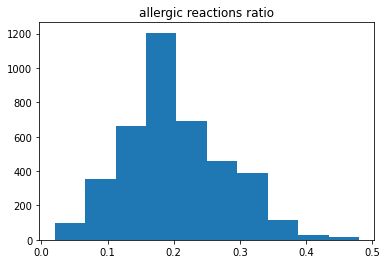

In [42]:
y_pred = df.iloc[:, 8]
ratio = y_pred / 50

plt.hist(ratio)
plt.title("allergic reactions ratio")
plt.show()

In [54]:
# Compute the expected value and 94% density interval 
# of the predicted ratio, compare it with expected value 
# and 94% density interval of parameter p. Use arviz package.
ratio_expected = np.mean(ratio)
ratio_ci = az.hdi(ratio.to_numpy(), hdi_prob=0.94)

p_expected = np.mean(df.iloc[:, 7].to_numpy())
p_ci = az.hdi(df.iloc[:, 7].to_numpy(), hdi_prob=0.94)

print("Parameter p:")
print(f"Expected value: {p_expected}")
print(f"94% credible interval: [{p_ci[0]}, {p_ci[1]}]\n")

print("Predicted ratio:")
print(f"Expected value: {ratio_expected}")
print(f"94% credible interval: [{ratio_ci[0]}, {ratio_ci[1]}]\n")


Parameter p:
Expected value: 0.200272800625
94% credible interval: [0.105686, 0.297933]

Predicted ratio:
Expected value: 0.20074500000000003
94% credible interval: [0.08, 0.36]



In [58]:
# Compute the probability that ratio is lower than the average 
# probability from traditional vaccines 
# (count the number of simulated ratios that are smaller).

num_smaller = np.sum(ratio < 0.2)
prob_smaller = num_smaller / len(ratio)
print(f"Probability that ratio is lower than average probability: {ratio_prob}")

Probability that ratio is lower than average probability: 0.47975
